In [6]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns


In [7]:
twitter_data = pd.read_csv('/content/Tweets.csv')
twitter_data
df = twitter_data.dropna(subset=['sentiment'])
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [19]:
cat_id = {'Neutral':  1,#defening the catgories
          'negative': 0,
          'positive': 2}
df['class']= df['sentiment'].map(cat_id)
df.dropna(subset=['text', 'selected_text'], inplace=True)
df['class'].fillna(0, inplace=True)
print(df.isnull().sum()) #calculating the null values and sum
BATCH_SIZE = 512
NUM_EPOCHS = 80
X = df['text'].values
y = df['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
print(f"X_train: {X_train.shape},y_train:{y_train.shape}/n X_test :{X_test.shape},y_test : {y_test.shape}")


one_hot = CountVectorizer()
X_train_onehot = one_hot.fit_transform(X_train)
X_test_onehot = one_hot.transform(X_test)


#Creating a tensor dataset

class sentimentData(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.toarray()).float()
        self.y = torch.tensor(y).type(torch.LongTensor)
        self.len = len(self.X)
    def __len__(self):
        return self.len
    def __getitem__(self,idx):
        return self.X[idx],self.y[idx]
train_ds = sentimentData(X = X_train_onehot,y = y_train)
test_ds =  sentimentData(X_test_onehot,y_test)

train_loader = DataLoader(dataset=train_ds,batch_size = BATCH_SIZE, shuffle =True)
test_loader  = DataLoader(test_ds, batch_size= 15000)

#creating a neural network model

class sentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES,NUM_CLASSES,HIDDEN = 10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES,HIDDEN)
        self.linear2 = nn.Linear(HIDDEN,NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self,x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x
model = sentimentModel(NUM_FEATURES = X_train_onehot.shape[1],NUM_CLASSES=3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)

        # Check for NaN values in y_batch
        if torch.isnan(y_batch).any():
            print("Warning: NaN values found in y_batch. Skipping this batch.")
            continue

        loss = criterion(y_pred_log, y_batch.long())
        loss.backward()
        optimizer.step()

        curr_loss += loss.item()

    train_losses.append(curr_loss)
    print(f"Epoch {e}, Loss: {curr_loss}")


textID           0
text             0
selected_text    0
sentiment        0
class            0
dtype: int64
X_train: (13740,),y_train:(13740,)/n X_test :(13740,),y_test : (13740,)
Epoch 0, Loss: 29.873644590377808
Epoch 1, Loss: 26.01511460542679
Epoch 2, Loss: 21.875671684741974
Epoch 3, Loss: 18.18294721841812
Epoch 4, Loss: 15.295790553092957
Epoch 5, Loss: 13.138842761516571
Epoch 6, Loss: 11.494837641716003
Epoch 7, Loss: 10.203350692987442
Epoch 8, Loss: 9.156055241823196
Epoch 9, Loss: 8.299916446208954
Epoch 10, Loss: 7.577185094356537
Epoch 11, Loss: 6.964089170098305
Epoch 12, Loss: 6.433691009879112
Epoch 13, Loss: 5.983709096908569
Epoch 14, Loss: 5.572021543979645
Epoch 15, Loss: 5.222430914640427
Epoch 16, Loss: 4.910052046179771
Epoch 17, Loss: 4.626971572637558
Epoch 18, Loss: 4.370286643505096
Epoch 19, Loss: 4.145143777132034
Epoch 20, Loss: 3.9312561228871346
Epoch 21, Loss: 3.736486442387104
Epoch 22, Loss: 3.5612524151802063
Epoch 23, Loss: 3.40197029709816
Epoch 2

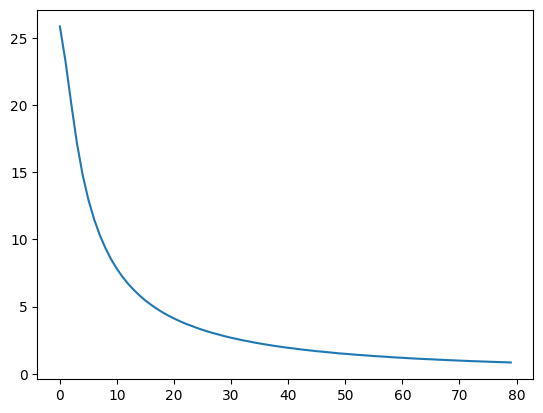

'The accuracy of the model is 80.7'

In [16]:
from matplotlib import pyplot as plt
sns.lineplot(x=list(range(len(train_losses))),y= train_losses)
plt.show()
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_text_pred = torch.argmax(y_test_pred_log, dim = 1)

y_test_pred_np = y_text_pred.squeeze().cpu().numpy()

acc = accuracy_score(y_pred = y_test_pred_np, y_true = y_test)
f"The accuracy of the model is {np.round(acc,3)*100}"

In [18]:
most_common_cnt = Counter(y_test).most_common()[0][1]
print(f"Naive Classifier: {np.round (most_common_cnt / len(y_test) * 100, 1)} %")

Naive Classifier: 68.6 %


In [26]:
from google.colab import drive
drive.mount('/content/drive')
torch.save(model.state_dict(), "/content/drive/MyDrive/sentiment_model.pt")
if model is not None:
  torch.save(model.state_dict(), "/content/drive/MyDrive/sentiment_model.pt")
  print(f" sucessfully saved")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 sucessfully saved


In [34]:
model  = sentimentModel(NUM_FEATURES = X_train_onehot.shape[1],NUM_CLASSES = 3)
model.load_state_dict(torch.load("/content/drive/MyDrive/sentiment_model.pt"))
test_text = "This is a beautiful flower"
test_text_tensor = torch.tensor(one_hot.transform([test_text]).toarray()).float()
with torch.no_grad():
    y_pred_log = model(test_text_tensor)
    y_pred = torch.argmax(y_pred_log, dim =1)
    print(f"Predicted sentiment: {y_pred}")
y_pred_np = y_pred.item()
sentiment_labels = ['negative', 'neutral', 'positive']
predicted_sentiment = sentiment_labels[y_pred_np]
print(f"Predicted sentiment: {predicted_sentiment}")
cat_id = {'negative': 0, 'neutral': 1, 'positive': 2}
if test_text in df['text'].values:
    actual_sentiment = df[df['text'] == test_text]['sentiment'].values[0]
    actual_sentiment_id = cat_id[actual_sentiment]
    if y_pred_np == actual_sentiment_id:
        print("The predicted sentiment is correct.")
    else:
        print("The predicted sentiment is incorrect.")
        print(f"Predicted sentiment: {y_pred_np}, Actual sentiment: {actual_sentiment_id}")
else:
    print("The test text does not exist in the DataFrame.")

Predicted sentiment: tensor([2])
Predicted sentiment: positive
The predicted sentiment is correct.
